In [1]:
#pip install pyforest

In [2]:
#pip install xgboost

In [3]:
#pip install -U imbalanced-learn

The 2012 US Army Anthropometric Survey (ANSUR II) was executed by the Natick Soldier Research, Development and Engineering Center (NSRDEC) from October 2010 to April 2012 and is comprised of personnel representing the total US Army force to include the US Army Active Duty, Reserves, and National Guard. In addition to the anthropometric and demographic data described below, the ANSUR II database also consists of 3D whole body, foot, and head scans of Soldier participants. These 3D data are not publicly available out of respect for the privacy of ANSUR II participants. The data from this survey are used for a wide range of equipment design, sizing, and tariffing applications within the military and has many potential commercial, industrial, and academic applications.

The ANSUR II working databases contain 93 anthropometric measurements which were directly measured, and 15 demographic/administrative variables explained below. The ANSUR II Male working database contains a total sample of 4,082 subjects. The ANSUR II Female working database contains a total sample of 1,986 subjects.


data dict:
https://data.world/datamil/ansur-ii-data-dictionary/workspace/file?filename=ANSUR+II+Databases+Overview.pdf


Hİnt for metric : Our mission to classify soldiers races via their body sclales. We want a balanced score for our predictions.

# Import libraries

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.ensemble import EasyEnsembleClassifier,BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler

#from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix,average_precision_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_auc_score, auc, roc_curve,precision_recall_curve,average_precision_score 
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [39]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [41]:
def plot_multiclass_precision_recall(clf, X_test, y_test,y_pred_prob, n_classes, figsize=(5,5)):
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
        precision[i], recall[i], _ = precision_recall_curve(y_test_dummies[:, i],
                                                            y_pred_prob[:, i])
        average_precision[i] = average_precision_score(y_test_dummies[:, i],
                                                            y_pred_prob[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='PR curve (area = %0.2f) for label %i' % (average_precision[i], i))

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

# Ingest the data from links below and make a dataframe
- Soldiers Male : https://query.data.world/s/h3pbhckz5ck4rc7qmt2wlknlnn7esr
- Soldiers Female : https://query.data.world/s/sq27zz4hawg32yfxksqwijxmpwmynq

In [42]:
pd.set_option('max_columns',150)
pd.set_option('max_rows',900)
pd.set_option('max_colwidth',200)

dfM=pd.read_csv("ANSUR II MALE Public.csv")
dfF=pd.read_csv("ANSUR II FEMALE Public.csv")

In [43]:
dfF.shape

(1986, 108)

In [44]:
dfF.columns

Index(['SubjectId', 'abdominalextensiondepthsitting', 'acromialheight',
       'acromionradialelength', 'anklecircumference', 'axillaheight',
       'balloffootcircumference', 'balloffootlength', 'biacromialbreadth',
       'bicepscircumferenceflexed',
       ...
       'Branch', 'PrimaryMOS', 'SubjectsBirthLocation', 'SubjectNumericRace',
       'Ethnicity', 'DODRace', 'Age', 'Heightin', 'Weightlbs',
       'WritingPreference'],
      dtype='object', length=108)

In [45]:
dfM.shape

(4082, 108)

In [46]:
dfM.columns

Index(['subjectid', 'abdominalextensiondepthsitting', 'acromialheight',
       'acromionradialelength', 'anklecircumference', 'axillaheight',
       'balloffootcircumference', 'balloffootlength', 'biacromialbreadth',
       'bicepscircumferenceflexed',
       ...
       'Branch', 'PrimaryMOS', 'SubjectsBirthLocation', 'SubjectNumericRace',
       'Ethnicity', 'DODRace', 'Age', 'Heightin', 'Weightlbs',
       'WritingPreference'],
      dtype='object', length=108)

In [47]:
df1=pd.concat([dfM,dfF])

In [48]:
df=df1.copy()

In [49]:
df.shape

(6068, 109)

In [50]:
df.duplicated().sum()

0

In [51]:
df.DODRace.value_counts()

1    3792
2    1298
3     679
4     188
6      59
5      49
8       3
Name: DODRace, dtype: int64

In [52]:
df=df[(df.DODRace==1)|(df.DODRace==2)|(df.DODRace==3)]

In [53]:
df.DODRace.value_counts()

1    3792
2    1298
3     679
Name: DODRace, dtype: int64

In [54]:
for feature in df.select_dtypes('object').columns:
    if len(df[feature].value_counts())<10:
        print(f"The feature is : {feature}\n{df[feature].value_counts()}\n-------------\n")
        

The feature is : Gender
Male      3899
Female    1870
Name: Gender, dtype: int64
-------------

The feature is : Component
Regular Army           2955
Army National Guard    2607
Army Reserve            207
Name: Component, dtype: int64
-------------

The feature is : Branch
Combat Service Support    3021
Combat Arms               1508
Combat Support            1240
Name: Branch, dtype: int64
-------------

The feature is : WritingPreference
Right hand                     5088
Left hand                       622
Either hand (No preference)      59
Name: WritingPreference, dtype: int64
-------------



In [55]:
df.select_dtypes('object').columns

Index(['Gender', 'Date', 'Installation', 'Component', 'Branch', 'PrimaryMOS',
       'SubjectsBirthLocation', 'Ethnicity', 'WritingPreference'],
      dtype='object')

# EDA
Tips :
- Drop unnecessary colums
- Drop DODRace class if value count below 500 (we assume that our data model can't learn if it is below 500)
- Find unusual value in Weightlbs

In [56]:
#df.head(1).T

In [57]:
 Drop_column=["subjectid","Date","PrimaryMOS","Ethnicity","SubjectsBirthLocation","SubjectId","SubjectNumericRace"]

In [58]:
df=df.drop(Drop_column,axis=1)

In [59]:
#df.isnull().sum()

In [60]:
df.describe().T

count     mean     std      min      25%  \
abdominalextensiondepthsitting 5769.000  247.254  37.458  155.000  220.000   
acromialheight                 5769.000 1408.630  78.303 1146.000 1353.000   
acromionradialelength          5769.000  328.072  20.445  249.000  314.000   
anklecircumference             5769.000  225.202  15.966  156.000  214.000   
axillaheight                   5769.000 1301.903  71.261 1062.000 1252.000   
balloffootcircumference        5769.000  244.408  16.804  186.000  233.000   
balloffootlength               5769.000  195.119  13.379  151.000  186.000   
biacromialbreadth              5769.000  399.706  30.124  283.000  377.000   
bicepscircumferenceflexed      5769.000  341.663  41.271  216.000  312.000   
bicristalbreadth               5769.000  274.903  19.240  197.000  262.000   
bideltoidbreadth               5769.000  491.455  42.012  357.000  461.000   
bimalleolarbreadth             5769.000   72.335   5.327   55.000   68.000   
bitragionchinarc               5769.000  324.962  17.050  267.000  314.000   
bitragionsubmandibulararc      5769.000  306.678  20.819  245.000  292.000   
bizygomaticbreadth             5769.000  139.529   7.249  116.000  134.000   
buttockcircumference           5769.000 1022.059  75.953  737.000  970.000   
buttockdepth                   5769.000  242.234  26.409  168.000  223.000   
buttockheight                  5769.000  872.113  54.065  656.000  834.000   
buttockkneelength              5769.000  610.450  33.121  479.000  587.000   
buttockpopliteallength         5769.000  498.332  28.513  380.000  478.000   
calfcircumference              5769.000  386.317  30.578  266.000  365.000   
cervicaleheight                5769.000 1479.952  83.591 1208.000 1421.000   
chestbreadth                   5769.000  283.233  20.612  213.000  269.000   
chestcircumference             5769.000 1024.207 100.376  695.000  952.000   
chestdepth                     5769.000  252.323  26.660  170.000  234.000   
chestheight                    5769.000 1254.290  78.882 1000.000 1199.000   
crotchheight                   5769.000  827.106  54.056  610.000  789.000   
crotchlengthomphalion          5769.000  622.694  45.087  473.000  592.000   
crotchlengthposterioromphalion 5769.000  351.880  29.807  243.000  331.000   
earbreadth                     5769.000   35.175   3.221   25.000   33.000   
earlength                      5769.000   62.606   4.862   46.000   59.000   
earprotrusion                  5769.000   22.227   3.149   13.000   20.000   
elbowrestheight                5769.000  240.553  28.596  138.000  222.000   
eyeheightsitting               5769.000  786.399  41.843  654.000  757.000   
footbreadthhorizontal          5769.000   98.915   6.659   77.000   94.000   
footlength                     5769.000  263.512  17.232  210.000  252.000   
forearmcenterofgriplength      5769.000  339.459  23.082  258.000  323.000   
forearmcircumferenceflexed     5769.000  295.662  29.857  200.000  273.000   
forearmforearmbreadth          5769.000  553.098  62.255  376.000  507.000   
forearmhandlength              5769.000  467.899  29.786  342.000  447.000   
functionalleglength            5769.000 1104.347  67.719  835.000 1057.000   
handbreadth                    5769.000   85.098   6.321   67.000   80.000   
handcircumference              5769.000  204.216  15.486  160.000  192.000   
handlength                     5769.000  189.575  11.423  150.000  182.000   
headbreadth                    5769.000  152.044   6.177  131.000  148.000   
headcircumference              5769.000  570.424  18.245  502.000  558.000   
headlength                     5769.000  196.641   8.323  168.000  191.000   
heelanklecircumference         5769.000  333.275  22.261  258.000  317.000   
heelbreadth                    5769.000   70.834   5.933   48.000   67.000   
hipbreadth                     5769.000  348.931  25.191  264.000  332.000   
hipbreadthsitting              5769.000  386.418  32.274

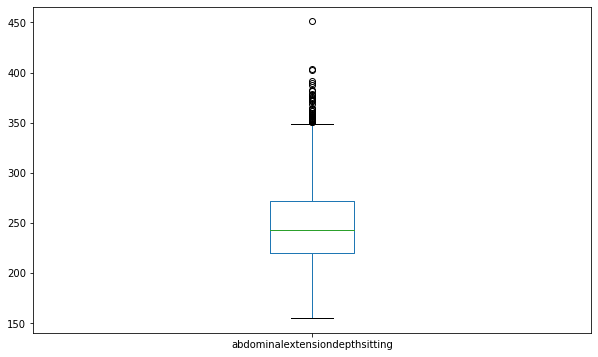

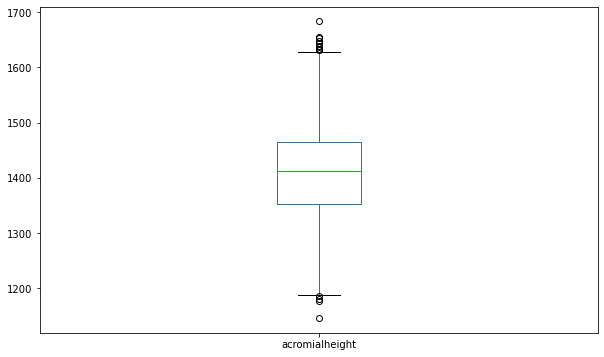

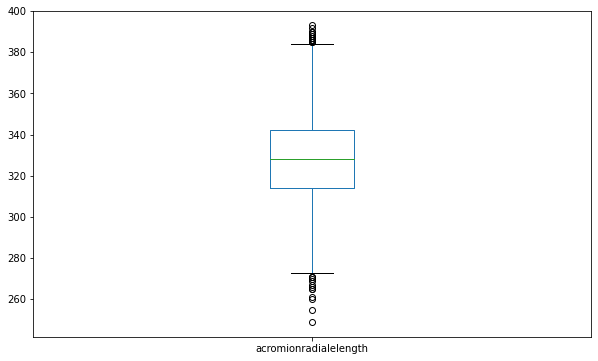

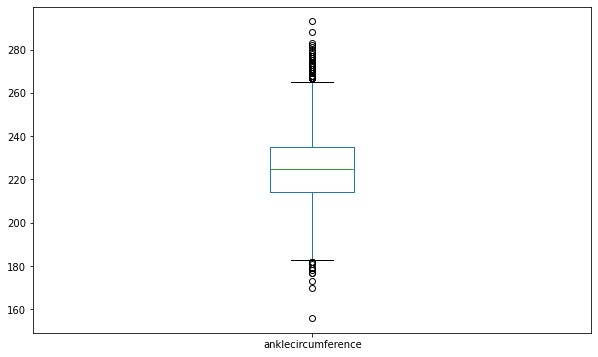

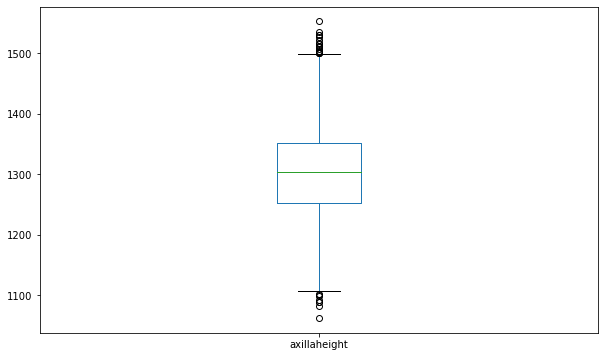

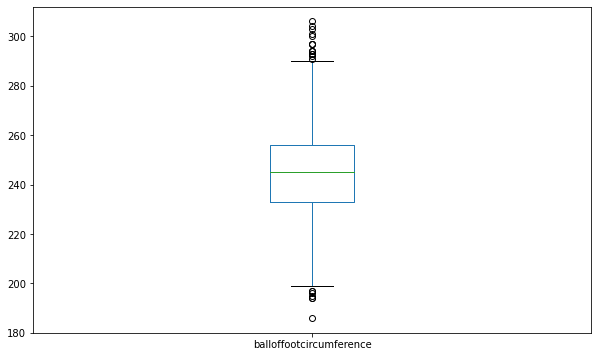

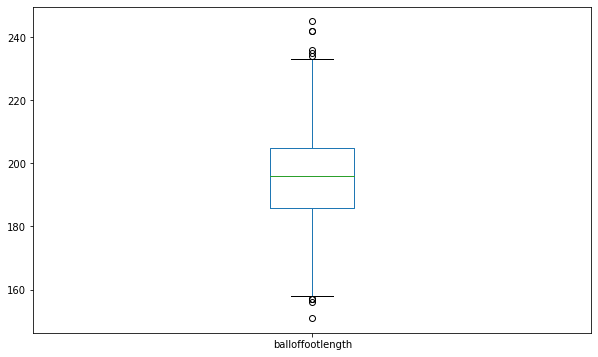

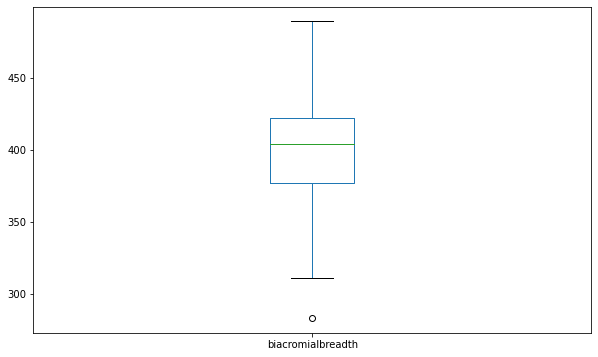

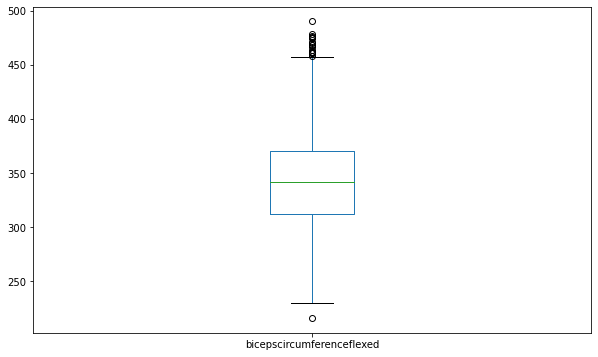

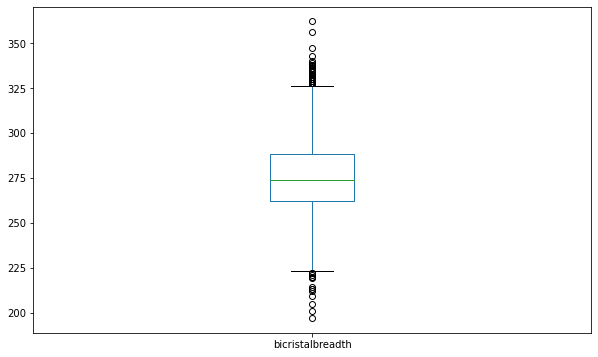

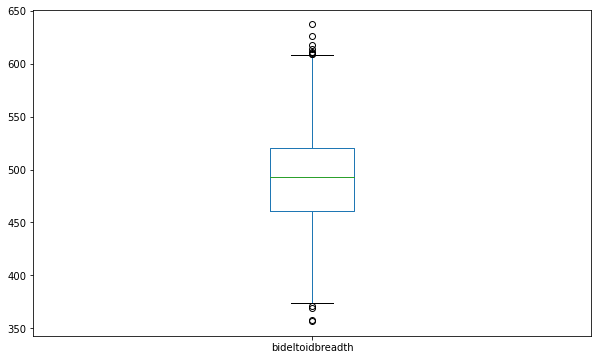

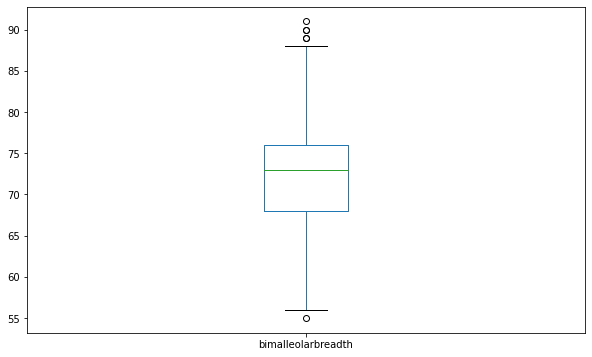

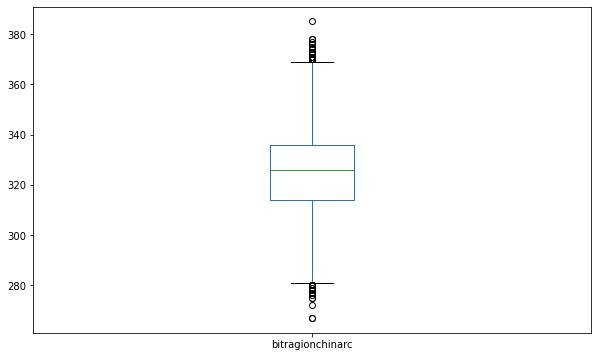

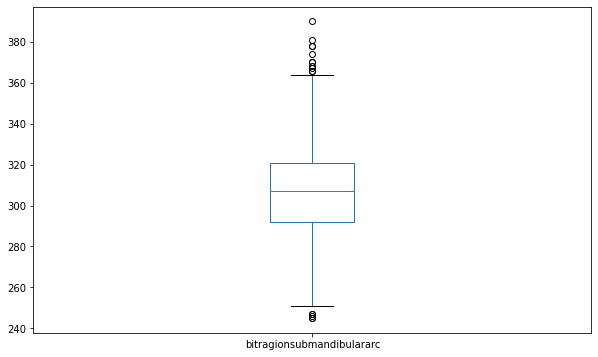

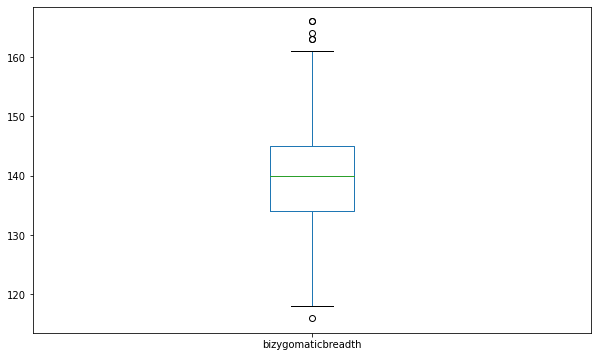

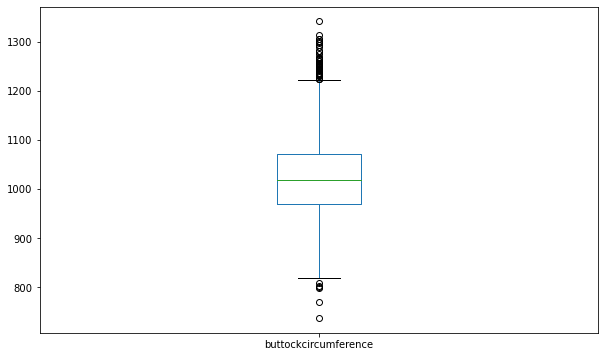

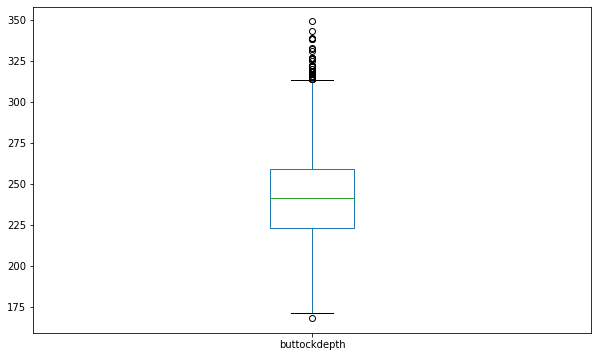

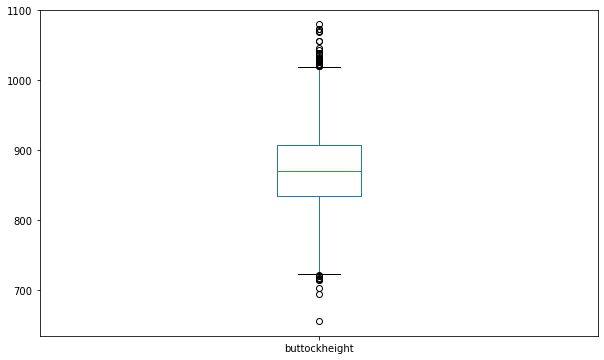

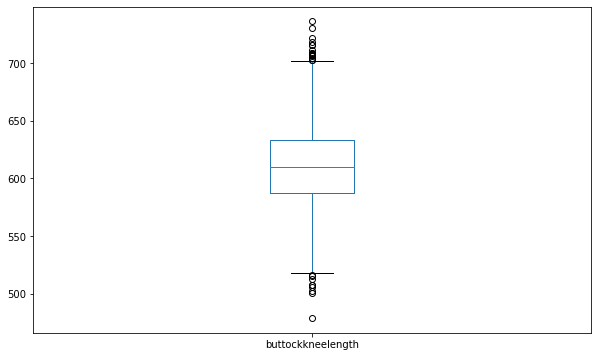

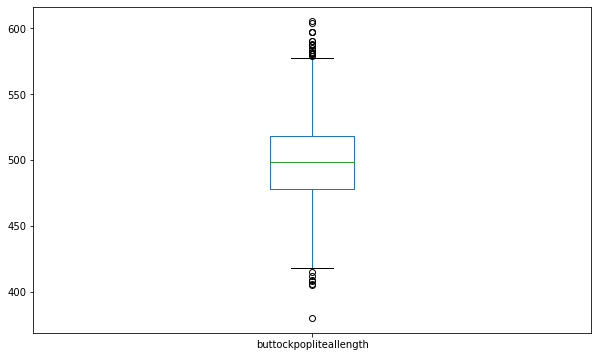

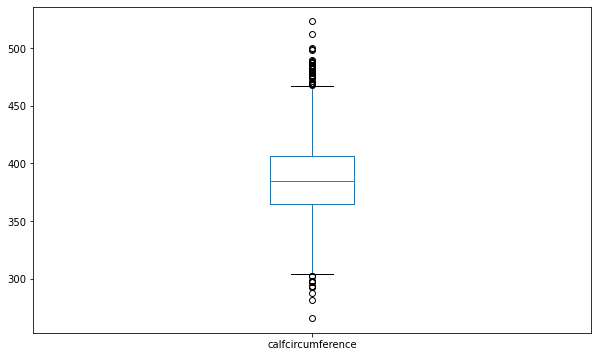

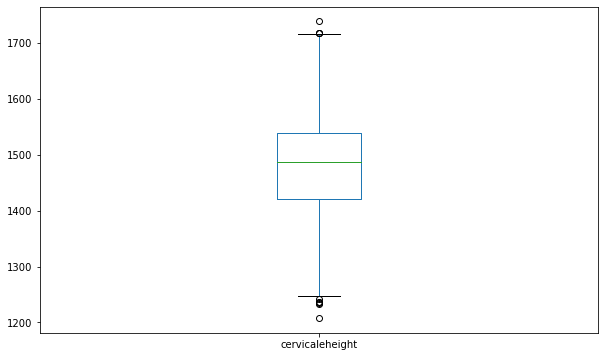

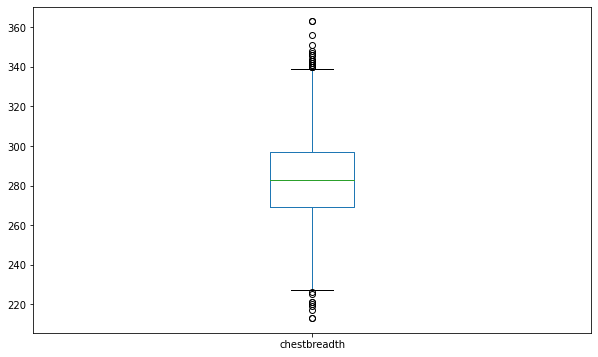

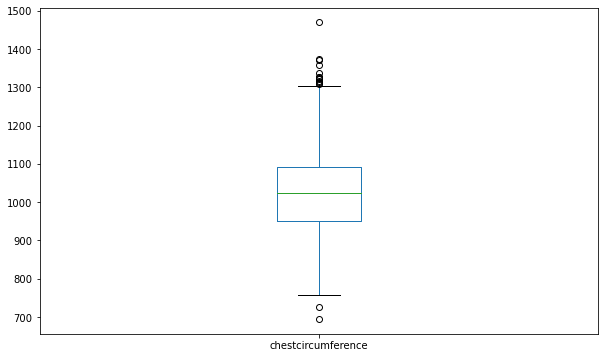

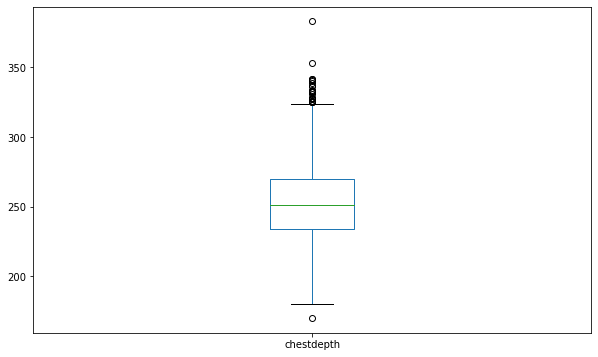

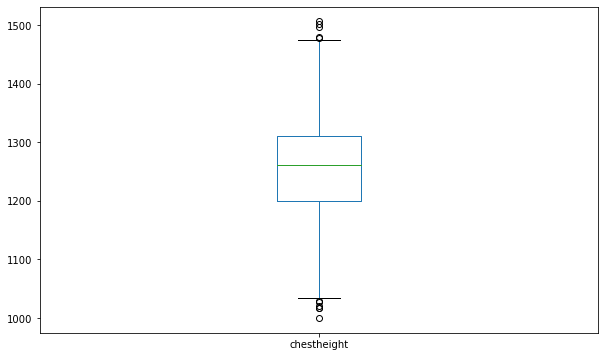

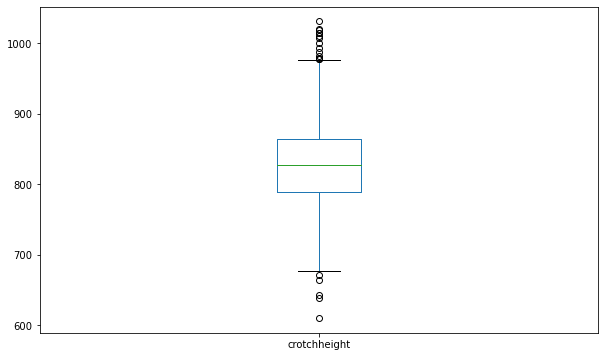

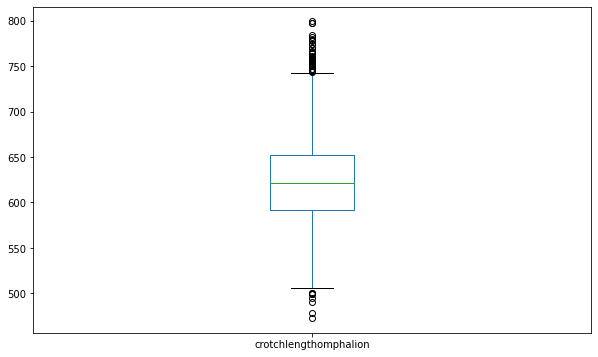

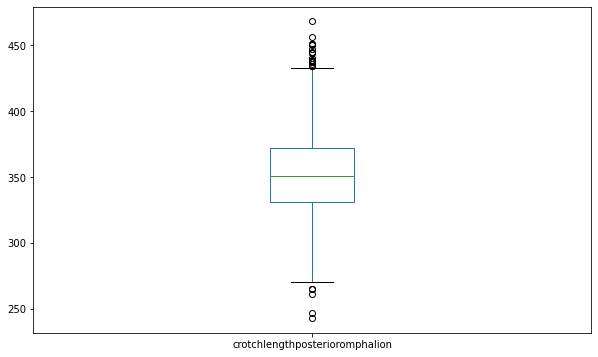

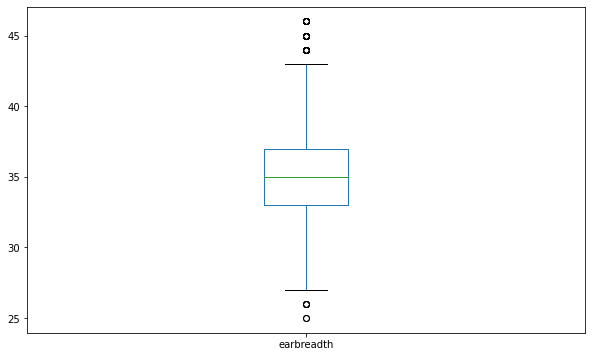

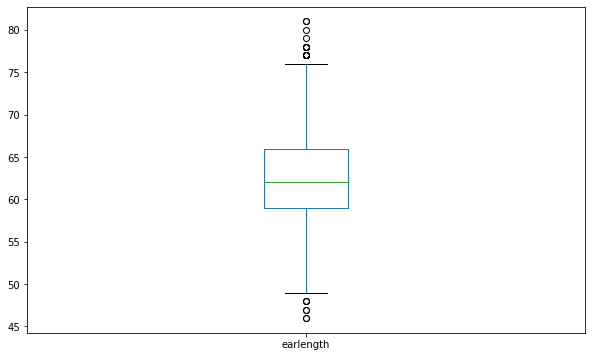

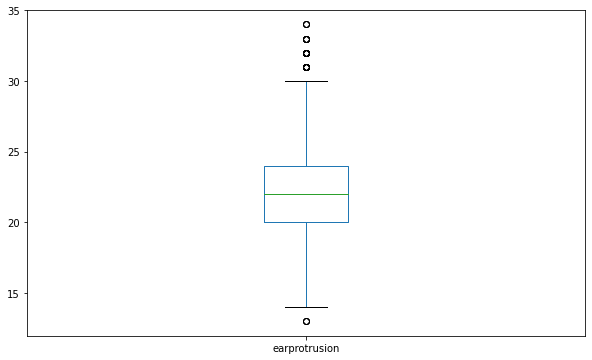

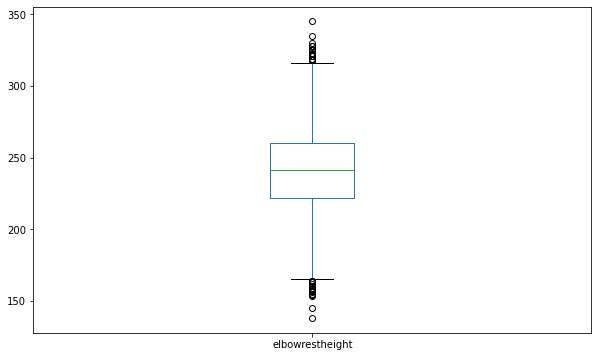

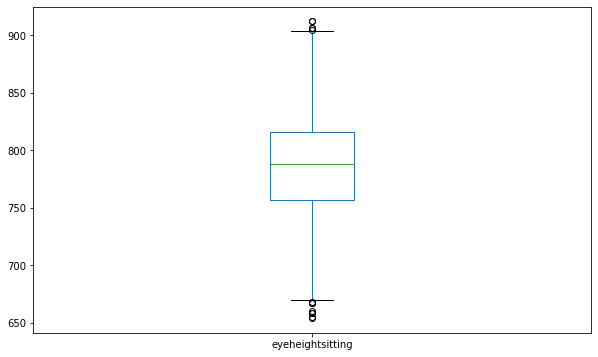

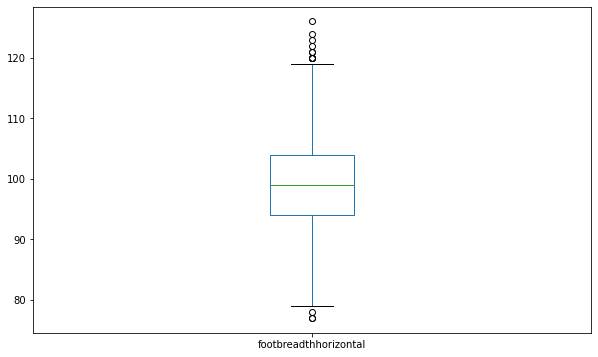

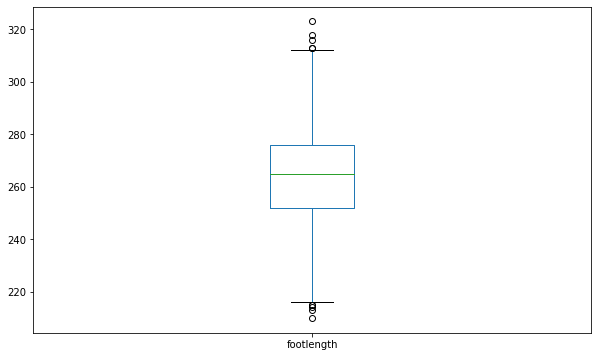

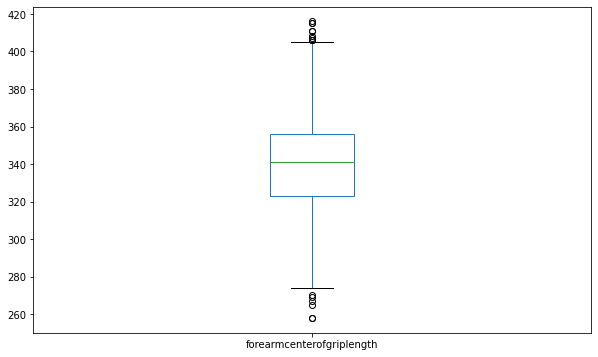

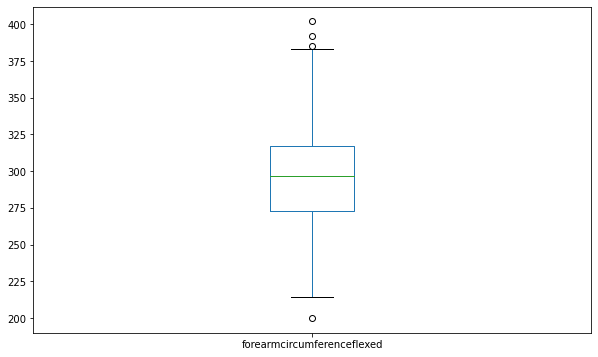

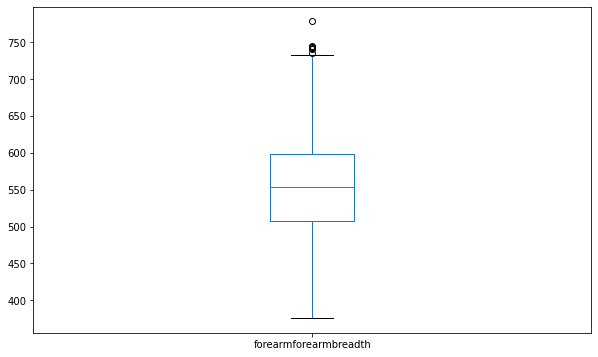

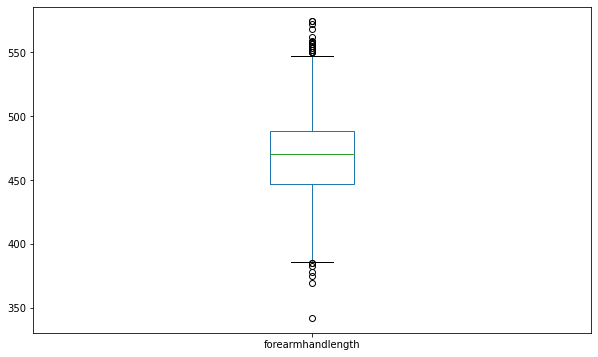

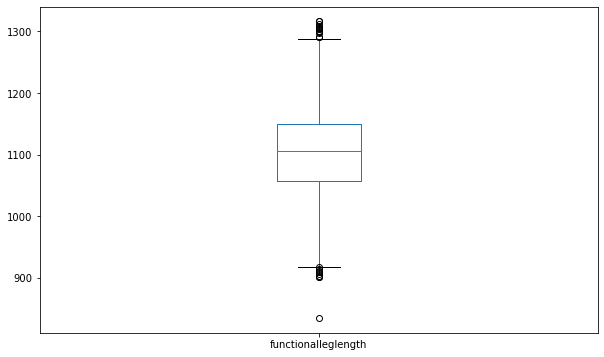

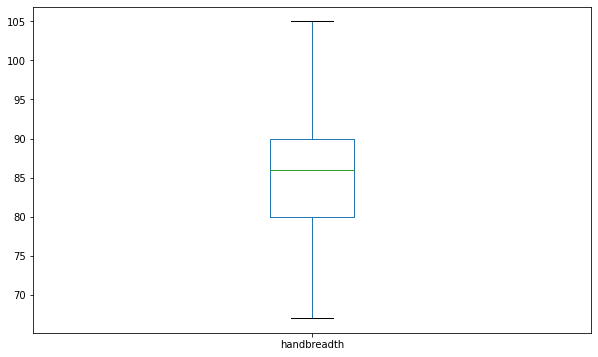

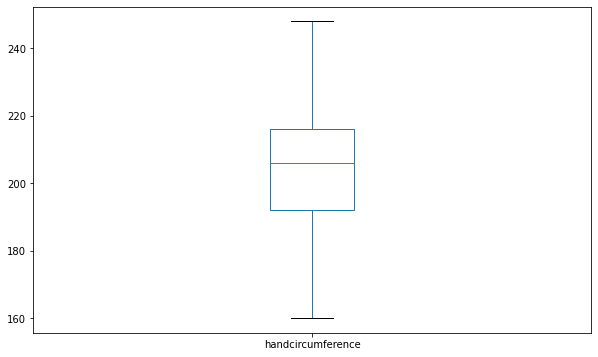

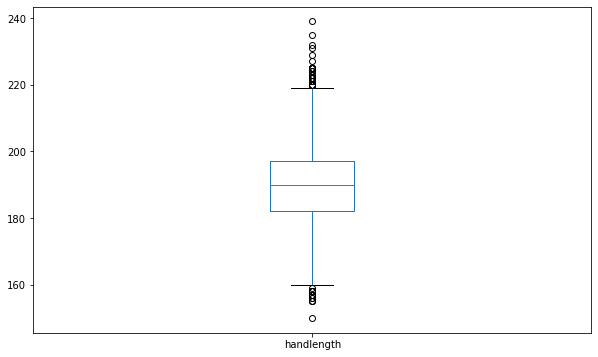

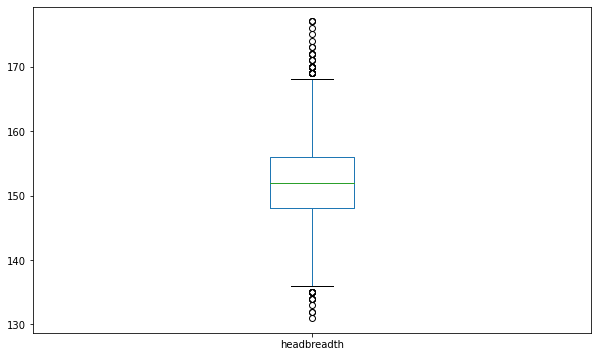

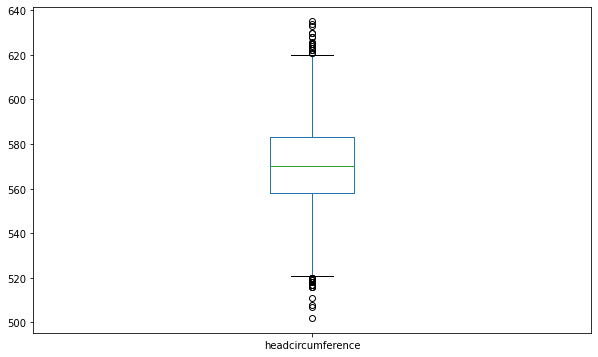

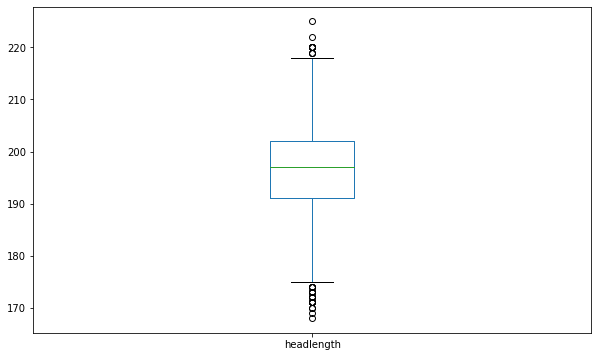

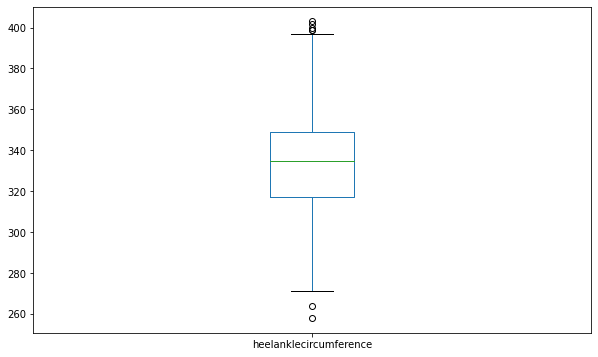

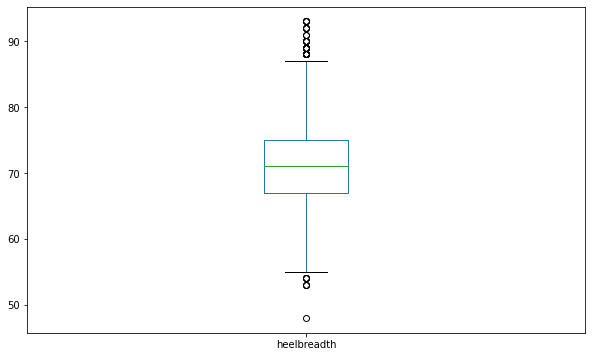

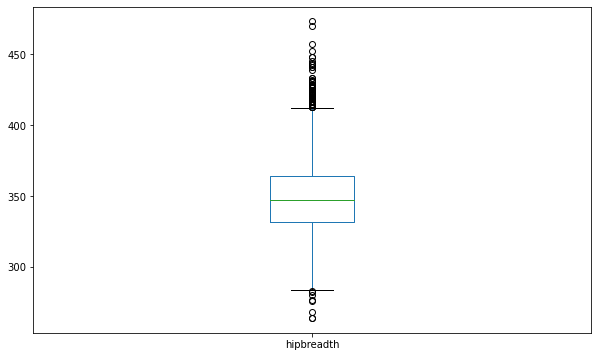

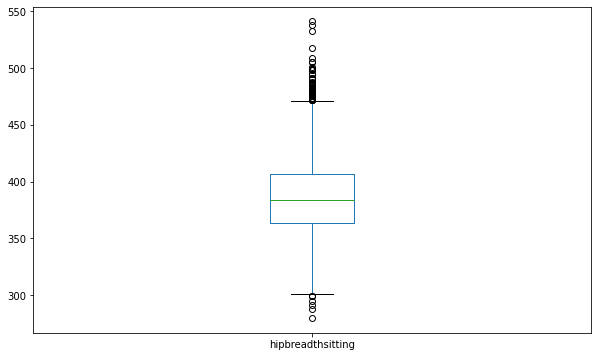

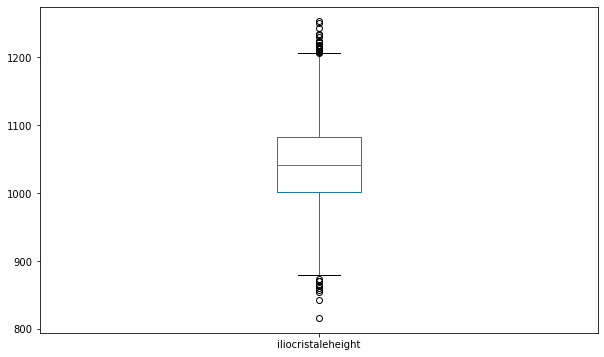

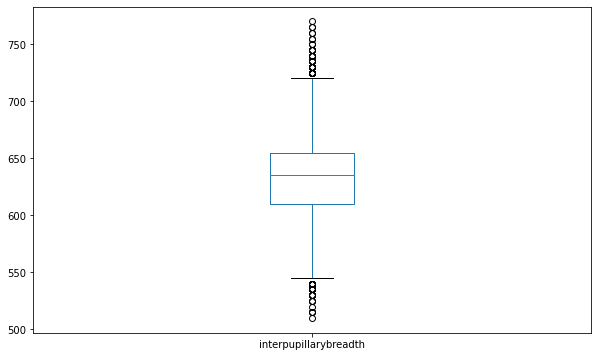

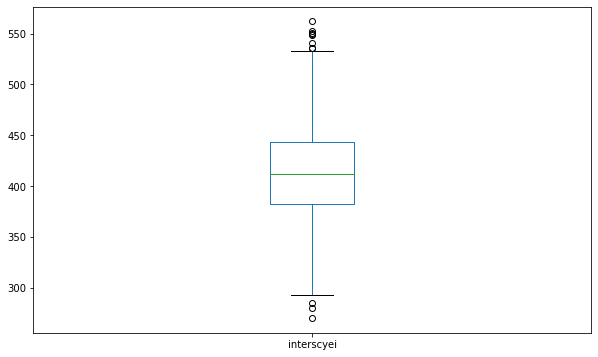

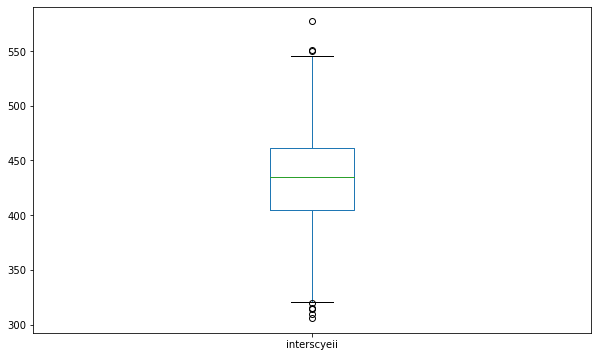

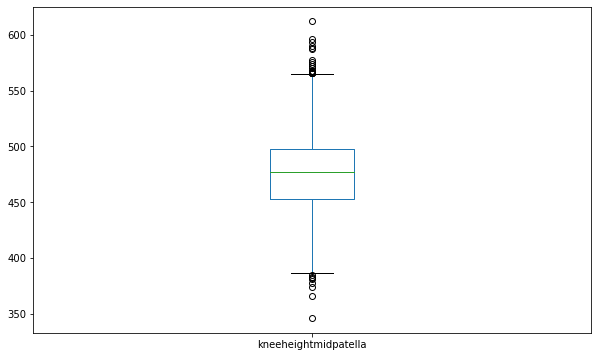

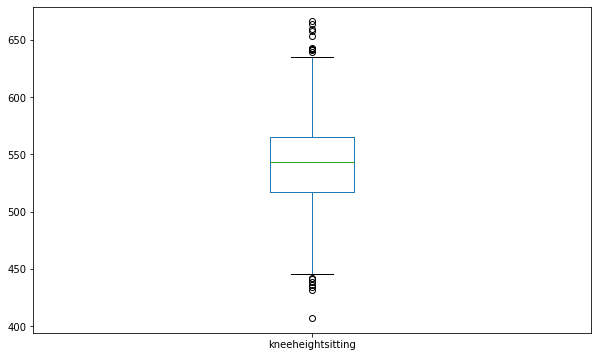

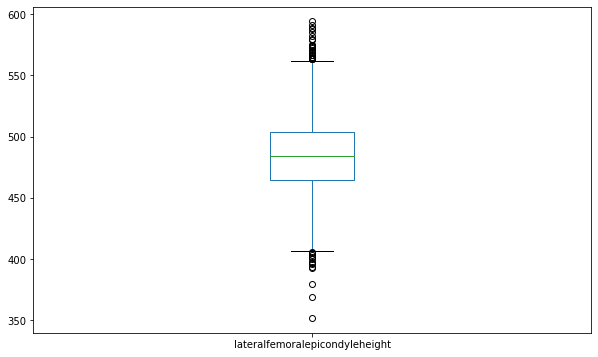

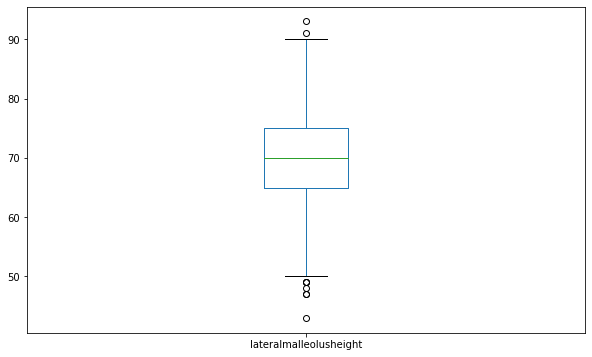

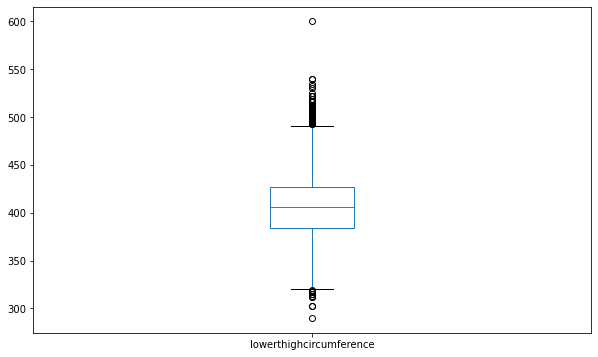

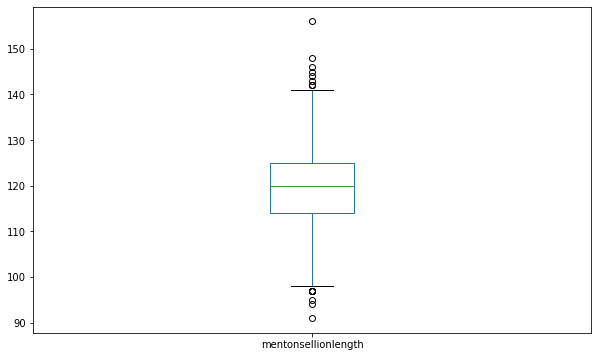

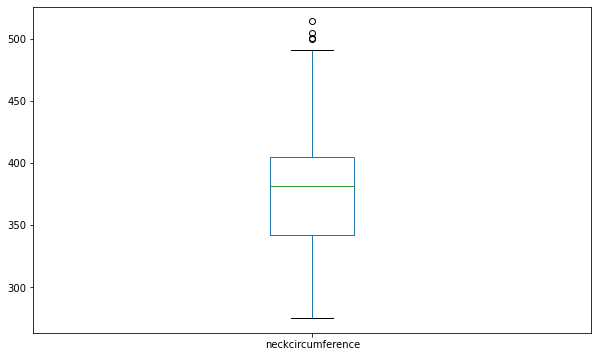

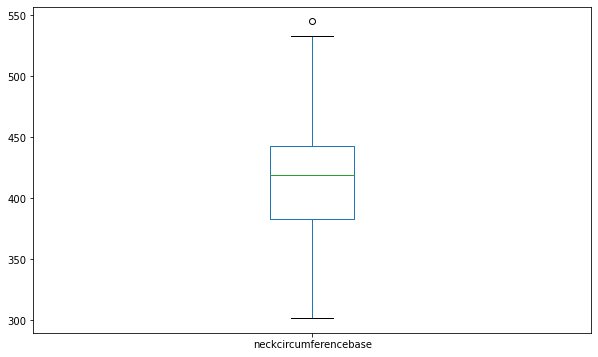

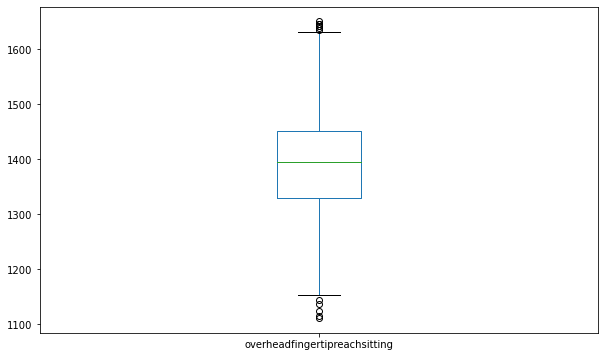

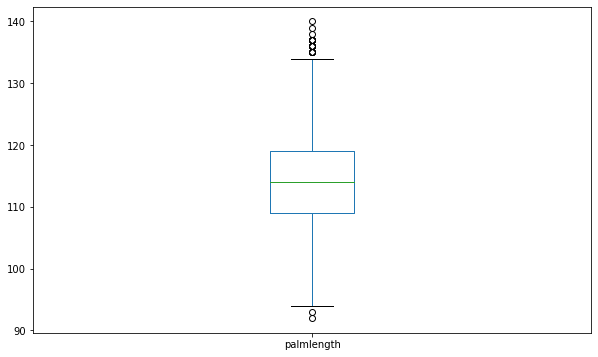

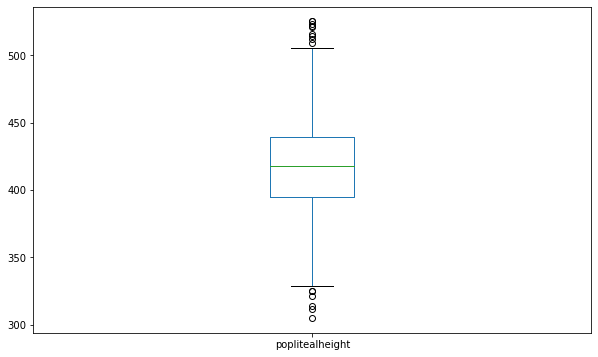

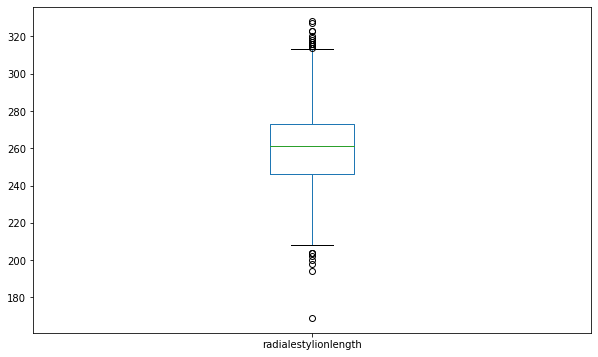

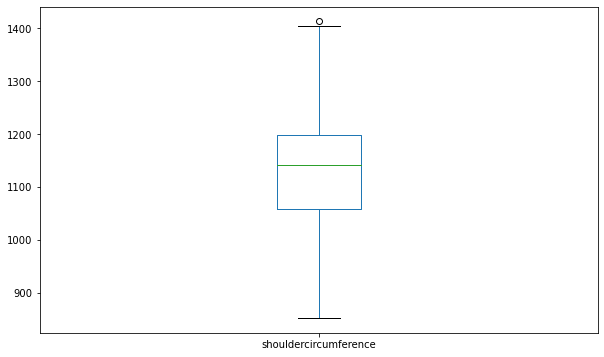

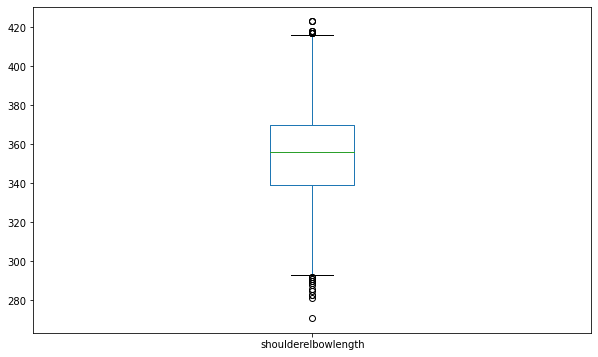

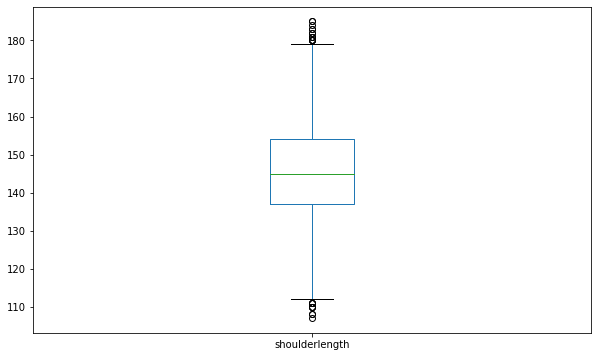

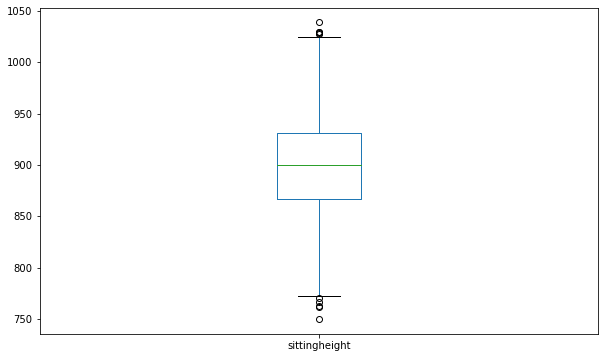

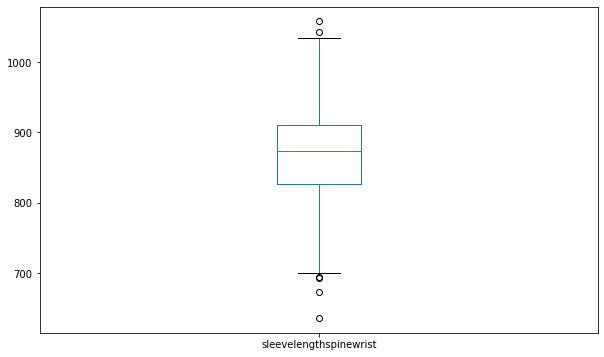

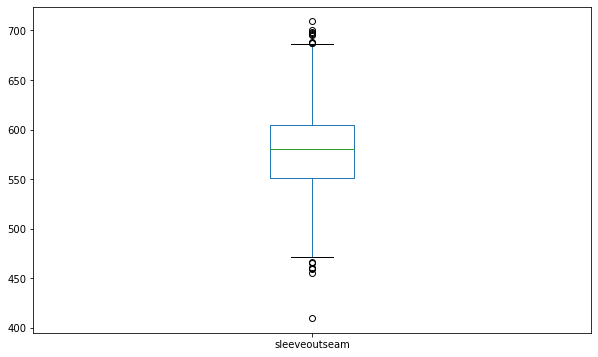

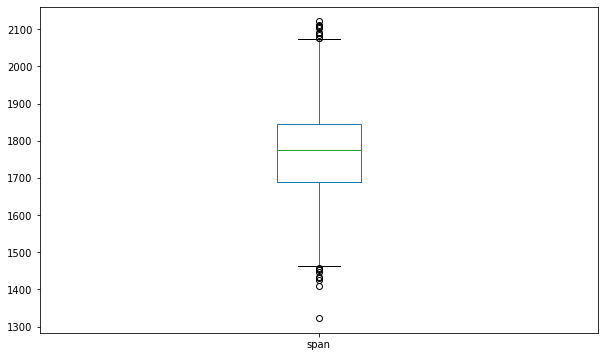

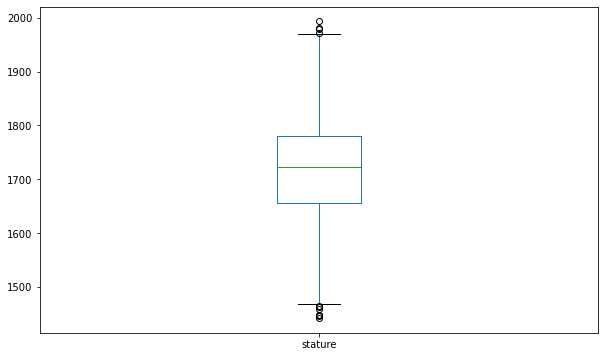

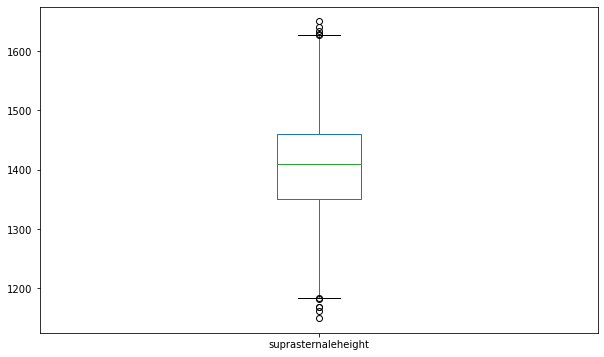

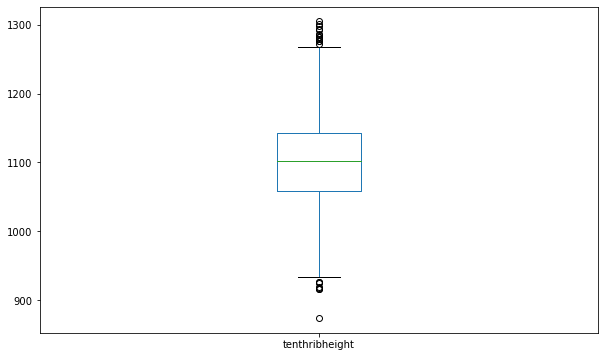

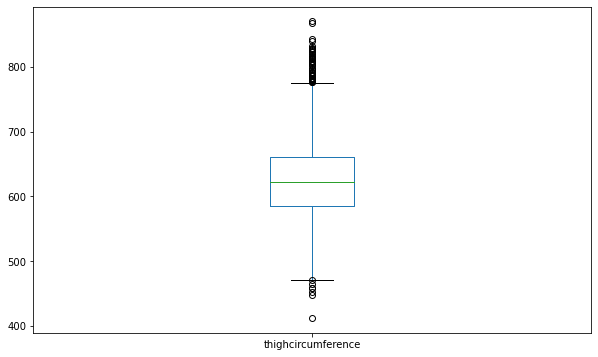

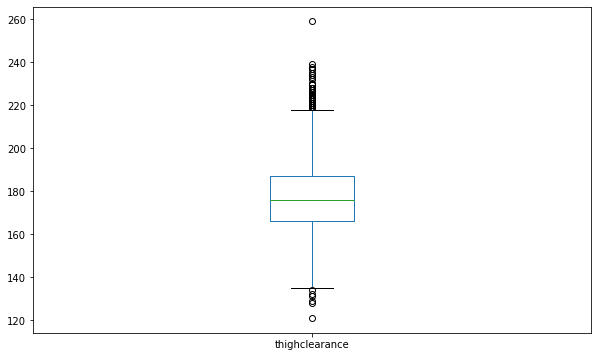

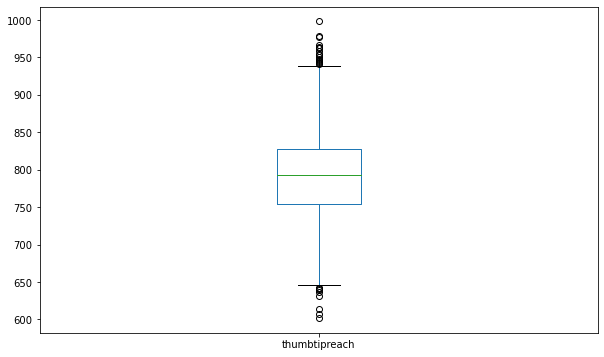

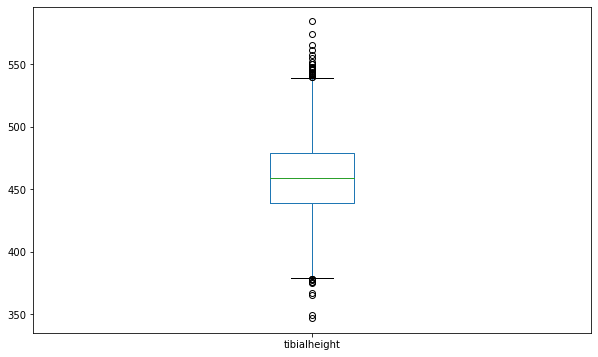

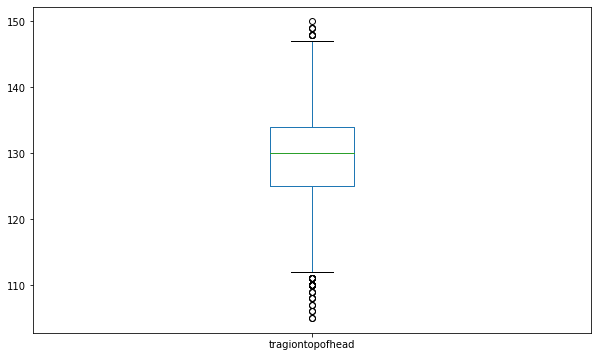

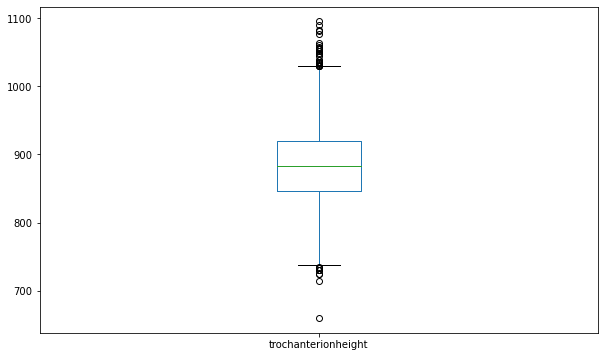

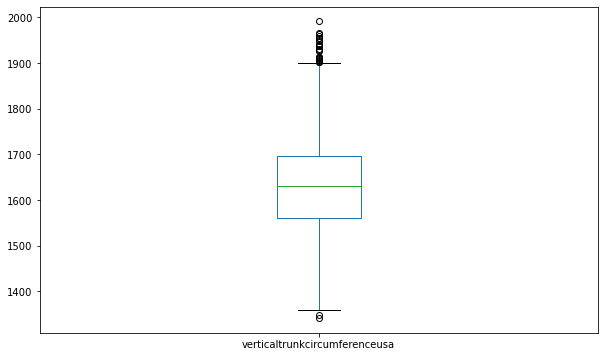

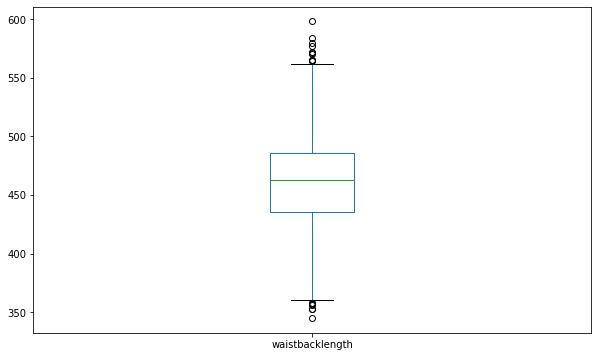

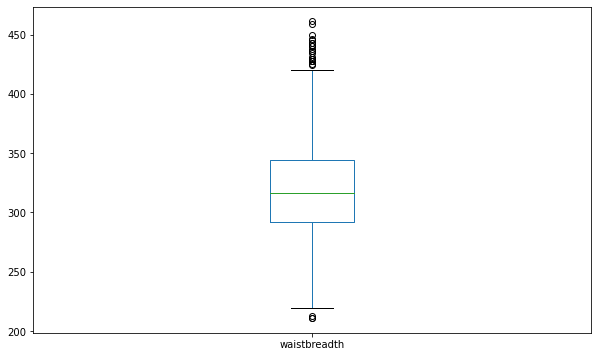

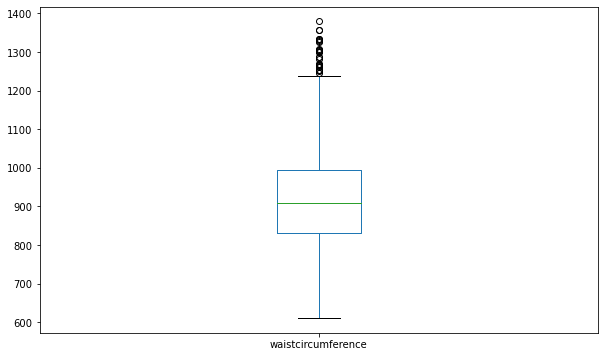

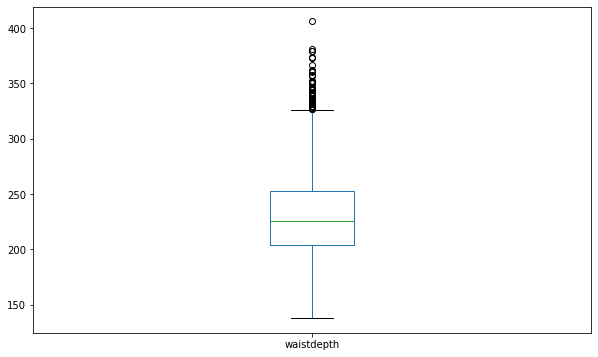

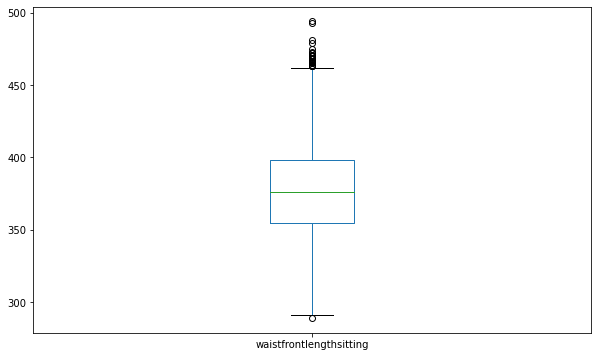

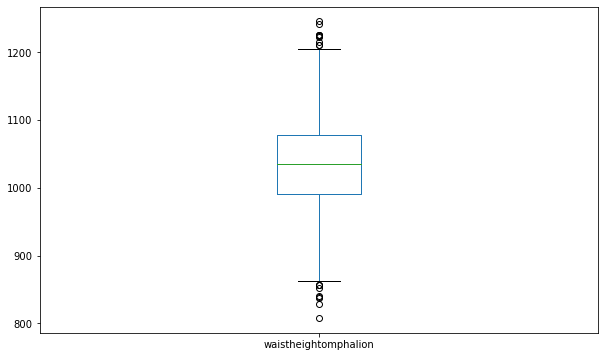

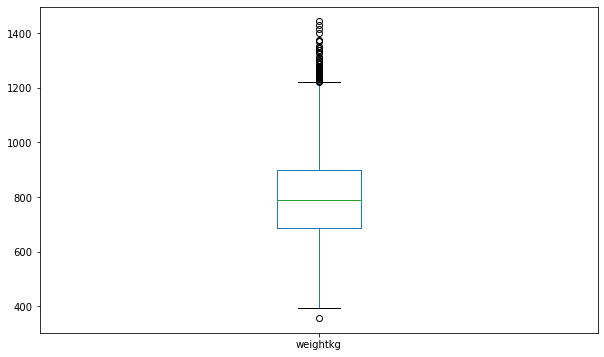

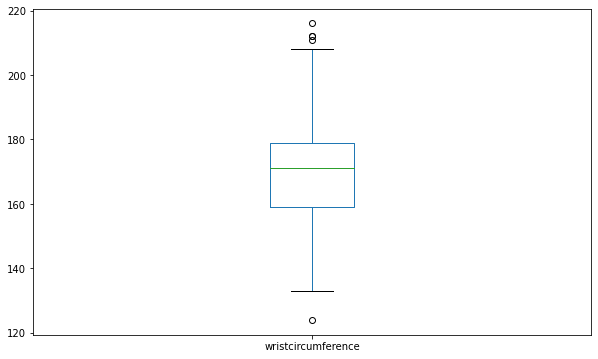

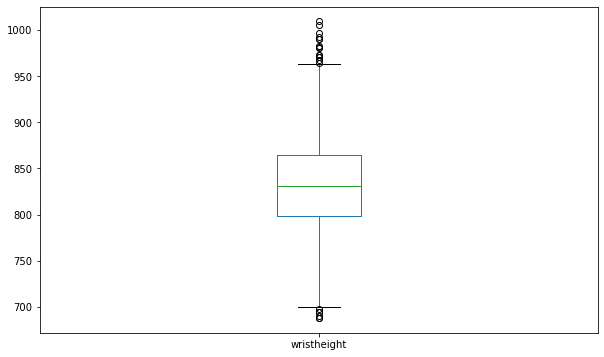

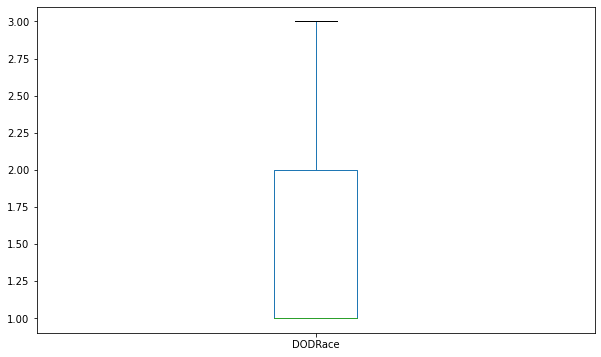

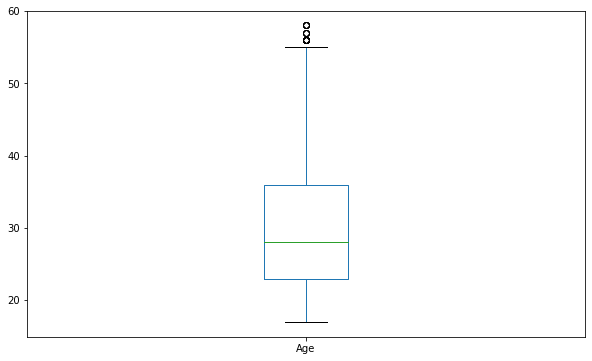

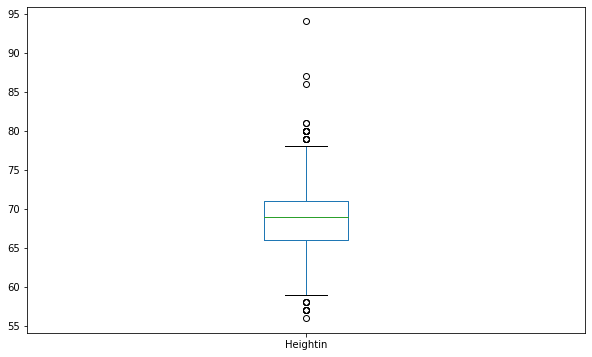

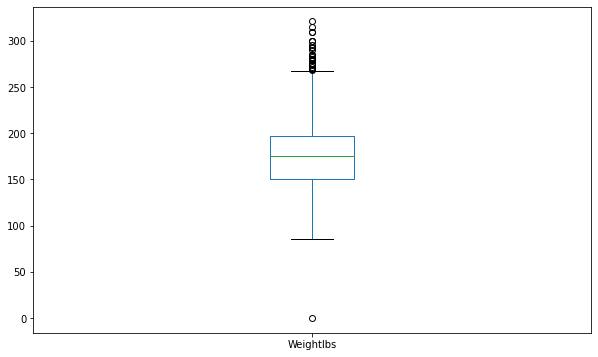

In [61]:
for i in df.select_dtypes("number").columns:
    df[i].plot(kind="box")
    plt.show()

In [62]:
#df.drop("Weightlbs",axis=1,inplace=True)

In [63]:
#df.corr()["DODRace"]

In [64]:
df.loc[df["Weightlbs"]==0, "Weightlbs"] = round(df.loc[df["Weightlbs"]==0, "weightkg"] / 10)

In [65]:
#df["DODRace"]=df["DODRace"].astype("object")

# DATA Preprocessing

In [66]:
X=df.drop("DODRace",axis=1)
y=df["DODRace"]

In [67]:
X = df.drop('DODRace',axis=1)
#X = pd.get_dummies(X, drop_first=True)
y = df['DODRace']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [69]:
#scaler = MinMaxScaler()

In [70]:
#scaled_X_train = scaler.fit_transform(X_train)
#scaled_X_test = scaler.transform(X_test)

In [71]:
ss_cols = X_train.drop(columns=["Gender", "Component", "Branch","Installation","WritingPreference"]).columns.to_list()

In [72]:
trans = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown="ignore"),
                            ["Gender", "Component", "Branch","Installation","WritingPreference"]),
                           ("scaler", StandardScaler(), ss_cols)])
#     pipe = Pipeline([("preprocessing", trans), ("model", model)])
#     cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="accuracy")
    
    
#     scores.append(cv_results)
#     names.append(name)
    
#     print(f"{name}: {cv_results.mean()}  ({cv_results.std()})")
#     pipe.fit(X_train, y_train)
#     y_pred = pipe.predict(X_test)
#     print(classification_report(y_test, y_pred))
#     print()


# Modelling Implementing
- You can use pipeline (optional)
- You can research over/undersampling methods and after selecting the best model, examine it to see if better scores can be obtained. (https://imbalanced-learn.org/stable/introduction.html)

## 1. Logistic Regression

In [73]:
operations=[("preprocessing", trans), ('log', LogisticRegression(class_weight="balanced",max_iter=10000000))]
pipe_model=Pipeline(steps=operations)

In [74]:
pipe_model.fit(X_train,y_train)
y_pred=pipe_model.predict(X_test)
y_train_pred=pipe_model.predict(X_train)
y_pred_prob=pipe_model.predict_proba(X_test)


In [75]:
test_data = pd.concat([y_test], axis=1)
test_data["pred"] = y_pred
test_data["pred_proba"] = y_pred_prob[:,1]


In [76]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[607  13 146]
 [  8 231  19]
 [ 28  14  88]]
              precision    recall  f1-score   support

           1       0.94      0.79      0.86       766
           2       0.90      0.90      0.90       258
           3       0.35      0.68      0.46       130

    accuracy                           0.80      1154
   macro avg       0.73      0.79      0.74      1154
weighted avg       0.87      0.80      0.82      1154



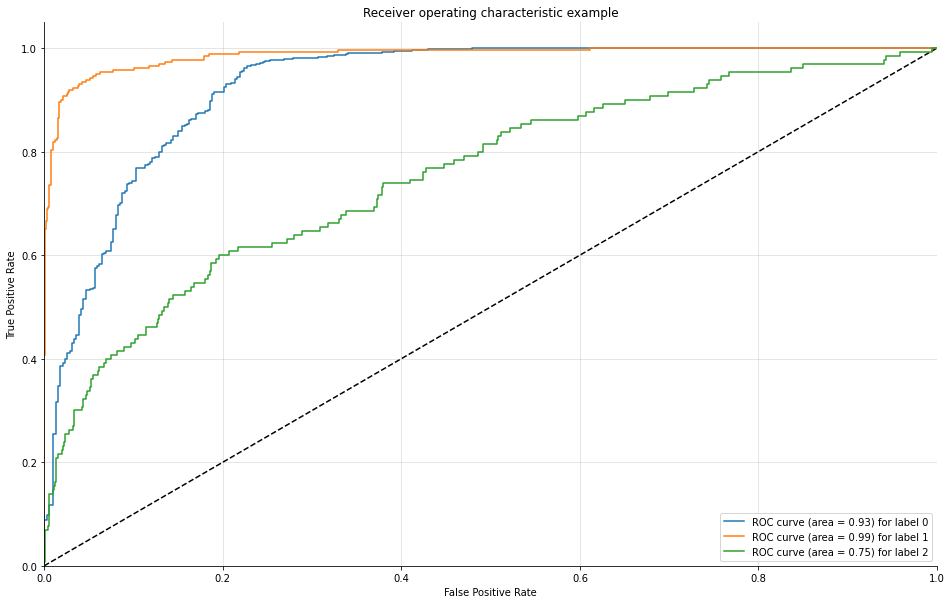

In [77]:
plot_multiclass_roc(pipe_model, X_test, y_test, n_classes=3, figsize=(16, 10))

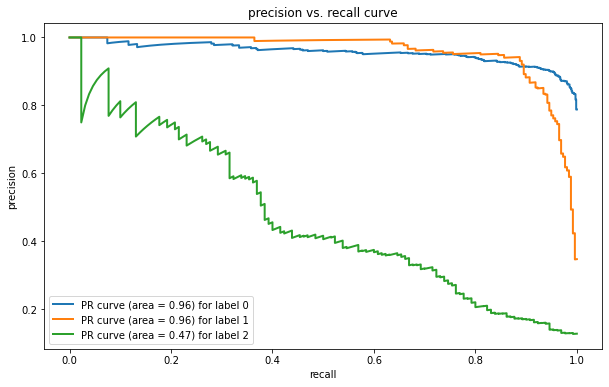

In [78]:
plot_multiclass_precision_recall(pipe_model,X_test,y_test,y_pred_prob,3)##Function  

In [79]:
#pipe_model.get_params()

In [80]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



[[607  13 146]
 [  8 231  19]
 [ 28  14  88]]
              precision    recall  f1-score   support

           1       0.94      0.79      0.86       766
           2       0.90      0.90      0.90       258
           3       0.35      0.68      0.46       130

    accuracy                           0.80      1154
   macro avg       0.73      0.79      0.74      1154
weighted avg       0.87      0.80      0.82      1154



##### GridSearchCV  for Logistic

In [ ]:
param_grid = {'log__l1_ratio': [0],'log__C':[5],'log__solver':['saga'],'log__max_iter': [100000]}
pipe_grid = GridSearchCV(pipe_model, param_grid, cv=10, scoring= 'f1')
pipe_grid.fit(X_train,y_train)
y_pred=pipe_grid.predict(X_test)
y_pred_prob=pipe_grid.predict_proba(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
plot_multiclass_precision_recall(pipe_grid,X_test,y_test,y_pred_prob,3)

## 2. Support Vector Classifier

In [97]:
operations=[("preprocessing", trans), ('svc', SVC(class_weight = "balanced",probability=True))]
pipe_svc=Pipeline(steps=operations)
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
y_pred_train = pipe_svc.predict(X_train)
y_pred_prob=pipe_svc.predict_proba(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val_mulclass(y_train, y_pred_train, y_test, y_pred)

[[634  13 119]
 [  8 235  15]
 [ 46  16  68]]
              precision    recall  f1-score   support

           1       0.92      0.83      0.87       766
           2       0.89      0.91      0.90       258
           3       0.34      0.52      0.41       130

    accuracy                           0.81      1154
   macro avg       0.72      0.75      0.73      1154
weighted avg       0.85      0.81      0.83      1154



train_set  \
Accuracy                                                          0.884   
Precision  [0.9700775766531216, 0.9328922495274102, 0.5494117647058824]   
Recall     [0.8678122934567085, 0.9490384615384615, 0.8506375227686703]   
f1         [0.9160997732426304, 0.9408960915157293, 0.6676197283774125]   

                                                                test_set  
Accuracy                                                           0.812  
Precision  [0.9215116279069767, 0.8901515151515151, 0.33663366336633666]  
Recall      [0.8276762402088773, 0.9108527131782945, 0.5230769230769231]  
f1           [0.8720770288858322, 0.900383141762452, 0.4096385542168675]

In [ ]:
plot_multiclass_precision_recall(pipe_svc,X_test,y_test,y_pred_prob,3)

##### GridSearchCV for SVC

In [ ]:
param_grid = {'svc__kernel': ['rbf', 'linear', 'poly'],'svc__C':[0.5,1,5],'svc__degree':[2,3]}
pipe_svc_grid = GridSearchCV(pipe_svc, param_grid, cv=10, scoring= 'f1')
pipe_svc_grid.fit(X_train,y_train)
y_pred=pipe_svc_grid.predict(X_test)
y_pred_prob=pipe_svc_grid.predict_proba(X_test)

In [ ]:
#pipe_svc_grid.get_params()

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
plot_multiclass_precision_recall(pipe_svc_grid,X_test,y_test,y_pred_prob,3)

## 3. Random Forest &XGBoost

In [87]:
models = []

#models.append(("LR", LogisticRegression(max_iter=10000000)))
#models.append(("SVC", SVC()))
models.append(("RF", RandomForestClassifier(class_weight = "balanced")))
#models.append(("EE", EasyEnsembleClassifier(class_weight = "balanced")))
#models.append(("BRF", BalancedRandomForestClassifier(class_weight = "balanced")))

#models.append(("ADA", AdaBoostClassifier()))
#models.append(("GB", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier(verbosity = 0, silent=True,class_weight = "balanced")))

In [88]:
scores = []
names = []


for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1845)
    pipe = Pipeline([("preprocessing", trans), ("model", model)])
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="f1_weighted")
    
    
    scores.append(cv_results)
    names.append(name)
    
    print(f"{name}: {cv_results.mean()}  ({cv_results.std()})")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    print()

<IPython.core.display.Javascript object>

RF: 0.7519749076306788  (0.014489952202213838)
              precision    recall  f1-score   support

           1       0.80      0.99      0.88       766
           2       0.92      0.70      0.79       258
           3       0.67      0.05      0.09       130

    accuracy                           0.82      1154
   macro avg       0.80      0.58      0.59      1154
weighted avg       0.81      0.82      0.77      1154




<IPython.core.display.Javascript object>

XGB: 0.8296546570574226  (0.014461376923503907)
              precision    recall  f1-score   support

           1       0.87      0.96      0.91       766
           2       0.88      0.90      0.89       258
           3       0.57      0.22      0.31       130

    accuracy                           0.86      1154
   macro avg       0.77      0.69      0.70      1154
weighted avg       0.84      0.86      0.84      1154




In [ ]:
pd.DataFrame(scores, index=names, columns=[i for i in range(1,11)]).T ##f1_weighted score

##### Gridsearch cv for rf and xgb

In [95]:
grid_model={XGBClassifier(verbosity = 0, silent=True):{"model__n_estimators":[100, 300],'model__max_depth':[3,5,6],"model__learning_rate": [0.1, 0.3],"model__subsample":[0.5, 1], "model__colsample_bytree":[0.5, 1]},
            RandomForestClassifier(class_weight = "balanced"):{'model__n_estimators':[50, 100, 300],'model__max_features':[2, 3, 4],'model__max_depth':[3, 5, 7, 9],'model__min_samples_split':[2, 5, 8]}}

In [96]:

for i in grid_model:
    pipe = Pipeline([("preprocessing", trans), ("model", i)])
    model_gridCV = GridSearchCV(pipe, grid_model[i], cv=10)
    model_gridCV.fit(X_train,y_train)
    y_pred=model_gridCV.predict(X_test)
    print(f"The model is: {i}, best parameter: {model_gridCV.best_params_}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("-----------------------------")   
       
       

The model is: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, silent=True, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=0), best parameter: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.3, 'model__max_depth': 6, 'model__n_estimators': 300, 'model__subsample': 0.5}
[[737  12  17]
 [ 20 230   8]
 [ 82  18  30]]
              precision    recall  f1-score   support

           1       0.88      0.96      0.92       766
           2       0.88      0.89 

# Choose the best model based on the metric you choose and make a random prediction

In [119]:
col=X.select_dtypes("number").columns
categoric=X.select_dtypes("object").columns
categoric

Index(['Gender', 'Installation', 'Component', 'Branch', 'WritingPreference'], dtype='object')

In [158]:
X_pred=X.iloc[1]
for i in X.columns:
    if i in categoric:
        X_pred[i]=X[i].mode()[0]
    else:    
        X_pred[i]=np.random.randint(X[i].mean())

In [160]:
X_pred=np.array(X_pred).reshape(1,101)

In [165]:
X_pred=pd.DataFrame(X_pred,columns=X.columns)

In [143]:
operations=[("preprocessing", trans), ('log', LogisticRegression(class_weight="balanced",max_iter=10000000))]
final_model=Pipeline(steps=operations)


In [144]:
final_model.fit(X,y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Component',
                                                   'Branch', 'Installation',
                                                   'WritingPreference']),
                                                 ('scaler', StandardScaler(),
                                                  ['abdominalextensiondepthsitting',
                                                   'acromialheight',
                                                   'acromionradialelength',
                                                   'anklecircumference',
                                                   'axillaheight',
                                                   'balloffootcircumference',
                                                   'ballof...
      

In [166]:
final_model.predict(X_pred)

array([3], dtype=int64)

---
---